In [1]:
import numpy as np 
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 
sns.set_style("darkgrid", {"grid.color": ".6", 
                           "grid.linestyle": ":"})
    
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV

## Load Data

In [2]:
df = pd.read_csv('gold_price_data.csv',parse_dates=["Date"])

In [3]:
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
3,2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
4,2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


## Data Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


### checking is there are any null values present in the data

In [5]:
df.isnull().sum()

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

### There are no null values in the data

### Correlation Between Columns <br> We should always check if there is any correlation between the two columns of our dataset. If two or more columns are correlated with each other and none of them is a target variable then we must use a method to remove this correlation. Some of the popular methods are PCA(principal component Analysis). We can also remove one of two columns or make a new one using these two. 

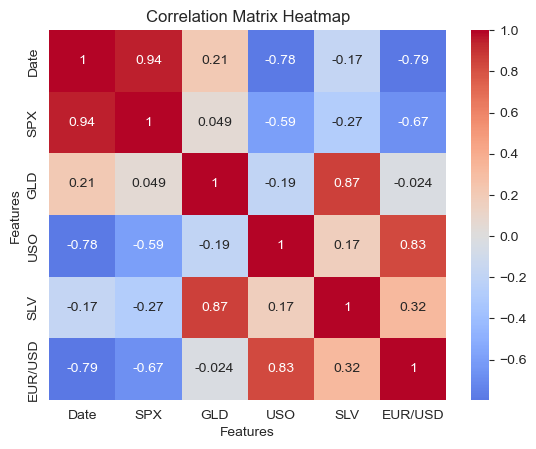

In [6]:
sns.heatmap(df.corr(),cmap='coolwarm',center=0,annot=True)

plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

### Here the two columns SLV and GLD are strongly correlated with each other compared to others, here we will drop SLV since GLD column also has a large correlation with our target column.

In [7]:
df.drop('SLV',axis=1, inplace=True)

## Data Wrangling

### Data wrangling is one of the main steps We use in a data science project to gain insight and knowledge from the data. We see data through every aspect and try to fetch most of the information from the dataframe. 

### We will first set the Date column as the index of the dataframe using the date as an index will add an advantage in plotting the data 

In [8]:
df.set_index('Date',inplace=True)

### We will first observe the change in Gold price with each consecutive day throughout the year.

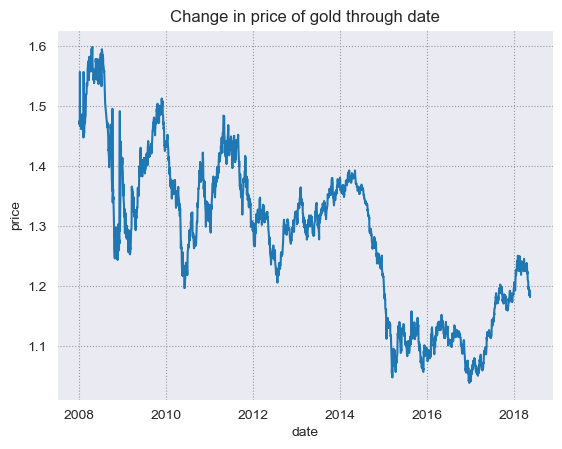

In [9]:
plt.plot(df['EUR/USD'])
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

### Through this graph, we are unable to find any good insight into the change in the price of gold. It looks very noisy, to see the trend in the data we have to make the graph smooth 

### Trend in Gold Prices Using Moving Averages 
### To visualize the trend in the data we have to apply a smoothing process on this line which looks very noisy. There are several ways to apply to smooth. In our project, we will take an average of 20 previous data points using the pandas rolling function. This is also known as the Moving Average.

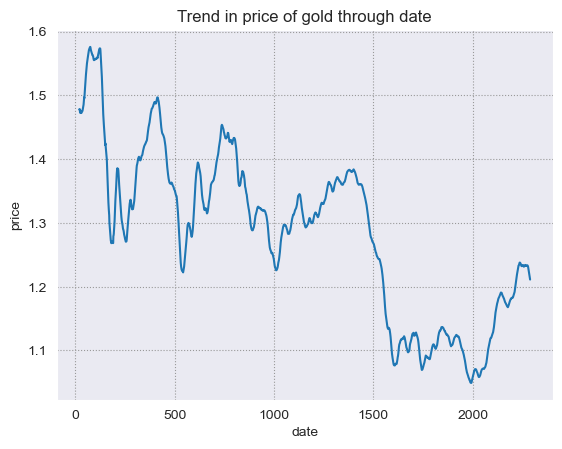

In [10]:
df['price_trend'] = df['EUR/USD'].rolling(window=20).mean()

# reset the index to date column
df.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 20 rows will be NAN
df["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()

### Now the graph looks less noisy and here we can analyze the trend in change in the gold price.

## Distribution  of Columns 
### To see the distribution of numerical columns we will plot the histogram of each column in one figure to do this we will use the Matplotlib subplot function.

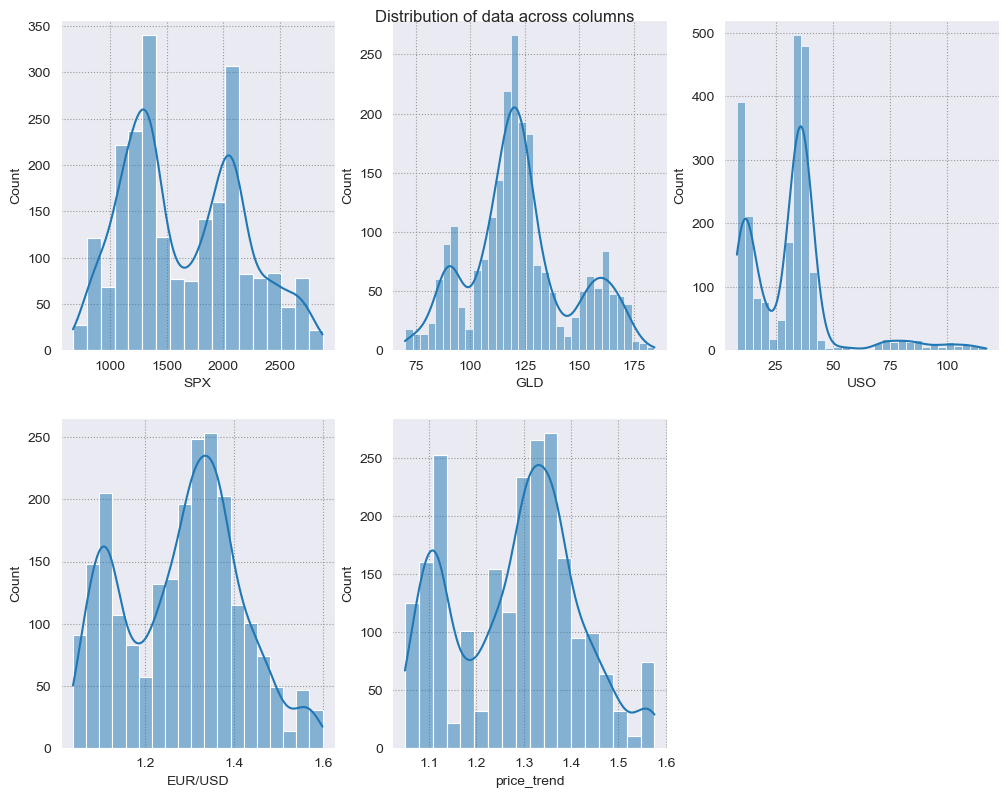

In [11]:
fig = plt.figure(figsize=(10,8))

fig.suptitle('Distribution of data across columns')
temp=df.drop('Date',axis=1).columns.tolist()

for i, item in enumerate(temp):
    plt.subplot(2,3,i+1)
    sns.histplot(data=df,x=item,kde=True)
plt.tight_layout(pad=0.4,w_pad=0.5,h_pad=2.0)
plt.show()

### Here we have used plt.figure to initialize a figure and set its size. One thing to note is that whenever we create a graph using matplotlib plot it automatically calls this function with the default figsize here We used sns.histplot function to create the histogram plot with kde equal True. The data distribution looks good However, we will check the skewness of each column using the pandas function.

In [12]:
df.drop('Date',axis=1).skew(axis=0,skipna=True)

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64

### Column USO has the highest skewness of 1.699331, so here we will apply square root transformation on this column to reduce its skewness. We can use different transformation functions to lower the skewness some are logarithmic transformation, inverse transformation, etc. 

In [13]:
df['USO'] = df['USO'].apply(lambda x:np.sqrt(x))

## Handling Outliers

### Outliers can have a very bad effect on our model like in linear regression if a data point is an outlier then it can add a very large mean square error. Removing outliers is a good process in EDA. Some models like Decisiontree and ensemble methods like RandomForests are not that much by outliers. However, it is always a good practice to handle the outlier.

### Plotting Boxplot to Visualize the Outliers 

### Boxplots are very useful in plotting the spread and skewness of the data, it is also useful in plotting the individual’s outlier data points, they consist of the box which represents points in the range of 25% to 75% quantiles. While the line in the middle of the box represents the median and the whisker at the end of the box shows the range of below 25 % and 75% excluding outliers.

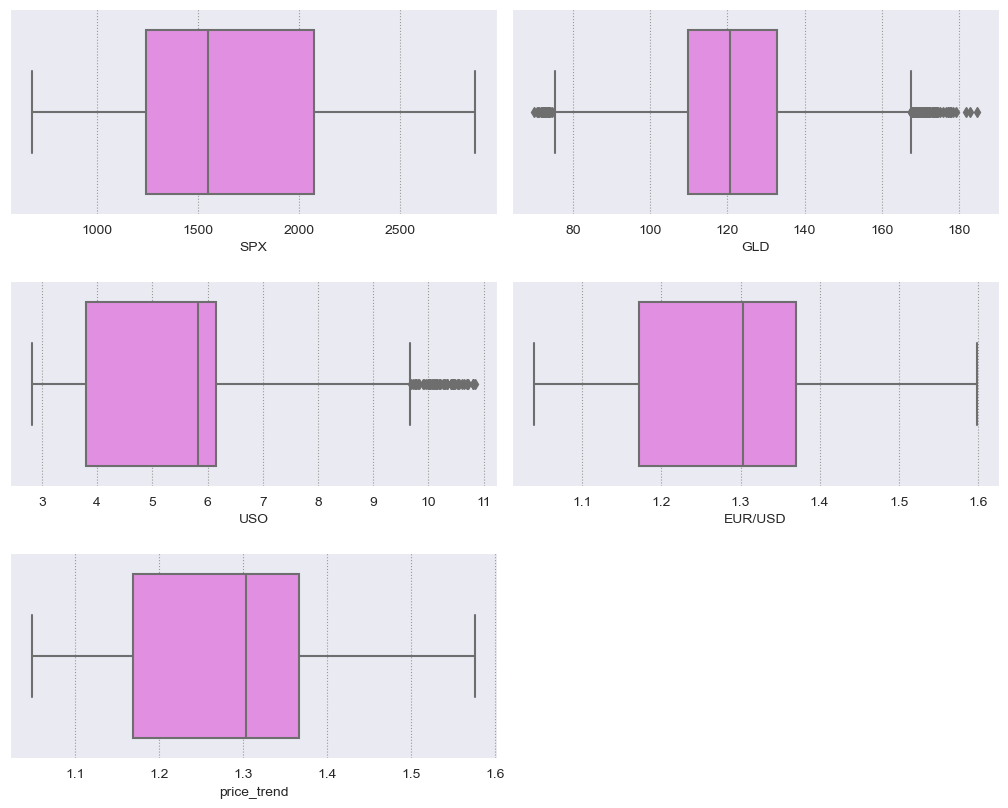

In [14]:
fig = plt.figure(figsize=(10, 8))
temp = df.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data=df, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

### There are some outliers present in 'GLD' and 'USO' column of the data,so we create a function to normalize the outlier present in the column.

In [15]:
def outlier_removal(column):
    # Capping the outlier rows with Percentiles
    upper_limit = column.quantile(.95)
    # set upper limit to 95percentile
    lower_limit = column.quantile(.05)
    # set lower limit to 5 percentile
    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    return column

In [16]:
df[['SPX','GLD','USO','EUR/USD']]=df[['SPX','GLD','USO','EUR/USD']].apply(outlier_removal)

In [17]:
df.isnull().sum()

Date            0
SPX             0
GLD             0
USO             0
EUR/USD         0
price_trend    19
dtype: int64

### This function removes all the outlier present in the data.

## Modeling the Data
### Before We start modeling the data must divide the data into train and test, so that after training the data We can see how much our data is learning the pattern and generalizing on new data points. it  is also a way to see that our model is not learning the noise in the data or say it is not overfitting the dataset

In [18]:
# select the features and target variable
X = df.drop(['Date', 'EUR/USD'], axis=1)

y = df['EUR/USD']
# dividing dataset in to train test
x_train, x_test,y_train, y_test = train_test_split(X, y, test_size=0.2)

## Scaling the Data 
### Before we train the model on our data we should perform scaling on our data to normalize. After scaling the data our mean of each column becomes zero and their standard deviation becomes 1. It is also called z-score normalization since we subtract the mean of the column from each element and divide it by the standard deviation of the column. It brings all the columns to the same scale and directly comparable with one another.

In [19]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

x_test_scaled = scaler.transform(x_test)


### It is always advisable to start fitting the data from a simple model and then move it to a complex one. One of the reasons for doing this is simple model takes less time and storage to train on the data. Also, many simple models work far better than complex ones and these models are also more interpretable than complex models.

## Lasso Regression 
### In this model, we have used linear regression with L1 Regularization, also with help of the make_pipeline object, we will use lasso regression with 2 degrees. We will also use the GridSearch object in every model to get the best-performing hyperparameter and lower the variance.

In [20]:
df.isnull().sum()

Date            0
SPX             0
GLD             0
USO             0
EUR/USD         0
price_trend    19
dtype: int64

In [21]:
# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with the mean of each column

# Fit and transform the imputer on the scaled training data
x_train_scaled = imputer.fit_transform(x_train_scaled)

# Transform the scaled test data using the trained imputer
x_test_scaled = imputer.transform(x_test_scaled)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter values to search over, including polynomial degrees
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4],  # Add degrees 1 through 4
    'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 30, 40]
}

# Create a pipeline that first applies polynomial features and then applies Lasso regression
pipeline = make_pipeline(PolynomialFeatures(), lasso)

# Create a GridSearchCV object with the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using the fitted model and the test data
y_pred = lasso_grid_search.predict(x_test_scaled)

# Compute the R-squared of the fitted model on the test data
r2 = r2_score(y_test, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ', lasso_grid_search.best_params_)
print('Best score: ', lasso_grid_search.best_score_)

R-squared:  0.9781322453712581
Best parameter values:  {'lasso__alpha': 0.0001, 'polynomialfeatures__degree': 4}
Best score:  0.9734095473082292


## RandomForestRegressor for Regression 
### In the second model, we will use the ensemble method to fit our training data. like in Random Forest it uses several decision trees to fit on the data, one thing to note is that in random forest regressor m number of rows are used for training which is always less than n (m<n). where n is the total number of original columns present in the training dataset, also for row points random forest select these row’s element.

In [22]:
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

# create instance of the Randomforest regressor
rf = RandomForestRegressor()

# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data

rf_grid_search.fit(x_train_scaled, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

r2 = r2_score(y_test,
              rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)

Best parameter values:  {'max_depth': 7, 'n_estimators': 100}
Best score:  0.9745738183421722
R-squared: 0.979847511898056


### Here We have used both RandomForest regressor and Gridsearchcv, The Gridsearch will help in selecting the best number of decision trees from 50,80,100. We have also specified the maximum depth of the tree as a parameter which can be 3,5 or 7. 

### The best parameter value shows that the model gives the best result when it takes the average result of 100 Decision trees having a maximum depth of 7

### These models are called Black box models since We won’t be able to visualize what is happening under the hood of the model however, we will plot the bar chart of the feature importance from the dataset.

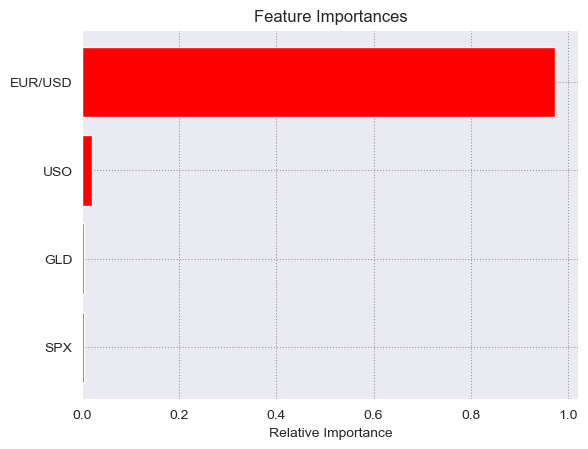

In [23]:
features = df.drop('Date',axis=1).columns

importances = rf_grid_search.best_estimator_.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)),
        importances[indices],
        color='red',
        align='center')

plt.yticks(range(len(indices)),
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### This feature importance graph shows that USO column plays a major effect (more than 2x) in deciding the gold price in USD.

## XGBoost Model for Regression 
### In Boosting Technique the data is fitted in several sequential Weak learning algorithm models which are only slightly better than random guessing. In each next sequential model more Weights are given to the points are which are misclassified/regressed by previous models 

### In our models, we will use the XGBOOST model for fitting our training dataset.

In [24]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
    y_train, model_xgb.predict(x_train_scaled)))

# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
      r2_score(y_test,
               model_xgb.predict(x_test_scaled)))

Xgboost Accuracy = 0.9994332432946104
Xgboost Accuracy on test data = 0.9859591724069148


## Model Explainability 
### In the black box model Boosting and Bagging, we will not be able to see the actual weights given to these columns however there are some libraries that we can use to the fraction of Weight out of 1 given to a particular column when we predict on a single vector. We will be using eli5 package to demonstrate the model explainability. 

### The name eli5 stands for “Explain like I’m 5” it’s a popular Python library that is used for debugging and explaining machine learning models. We will use eli5 to see the Weights of our best-performing model which is  XGBOOST best on its train and test accuracy.

In [26]:
import eli5 as eli
# weight of variables in xgboost model
# Get the names of the features
feature_names = x_train.columns.tolist()

# Explain the weights of the features using ELI5
eli.explain_weights(model_xgb,feature_names=feature_names)


Weight,Feature
0.9491,price_trend
0.0340,USO
0.0098,GLD
0.0070,SPX
